In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras import backend as K
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32').reshape(-1, 28, 28, 1) / 255.
x_test = x_test.astype('float32').reshape(-1, 28, 28, 1) / 255.

data_shape = x_train.shape[1:]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# sequential, functional API

class AE(keras.Model): # model을 상속받음 --> 이 class는 keras model로 동작
    def __init__(self, latent_dim): # model을 생성할 때 입력받는 변수
        super(AE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        encoder_inputs = keras.Input(shape=data_shape)
        x = layers.Conv2D(8, 3, activation='relu', strides=1, padding='same')(encoder_inputs)
        x = layers.MaxPooling2D((2,2), padding='same')(x)
        x = layers.Conv2D(16, 3, activation='relu', strides=1, padding='same')(x)
        x = layers.MaxPooling2D((2,2), padding='same')(x)
        x = layers.Conv2D(32, 3, activation='relu', strides=1, padding='same')(x)

        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(16, activation='relu')(x)
        z = layers.Dense(self.latent_dim, name="z")(x)
        
        encoder = keras.Model(encoder_inputs, z, name="encoder")
        return encoder

    def build_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))

        x = layers.Dense(7 * 7 * 16, activation='relu')(latent_inputs)
        x = layers.Reshape((7, 7, 16))(x)
        x = layers.Conv2DTranspose(16, 3, activation='relu', strides=1, padding='same')(x)
        x = layers.UpSampling2D()(x)
        x = layers.Conv2DTranspose(8, 3, activation='relu', strides=1, padding='same')(x)
        x = layers.UpSampling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(4, 3, activation='relu', strides=1, padding='same')(x)

        decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

        return decoder

    def call(self, x):
        z = self.encoder(x)
        x_decoded = self.decoder(z)
        return x_decoded

    def vae_loss(self, x, x_decoded):
        # loss - decoded가 원래 x와 유사하게 + latent 모양이 가우시안 형태 
        mse_loss = keras.losses.MSE(x, x_decoded)
        reshaped_mse = tf.reshape(mse_loss, (-1, 28*28))
        recon_loss = tf.reduce_sum(reshaped_mse, axis = -1) # 데이터 개수만큼 mse loss

        kl_loss = -0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean))\
                                        - K.exp(self.z_log_var)

In [ ]:
# AE 모델 만들기
latent_dim = 2
ae = AE(latent_dim)

# 모델 컴파일하기
ae.compile(optimizer='adam', loss='mse')
ae(x_test).shape

TensorShape([10000, 28, 28, 1])

In [ ]:
ae.summary()

In [ ]:
ae.encoder.summary()

In [ ]:
ae.decoder.summary()

In [ ]:
# loss fn이 
ae.fit(x_train, x_train, epochs=30, batch_size=512, validation_split=0.1)

1/1 [==============================] - 0s 18ms/step


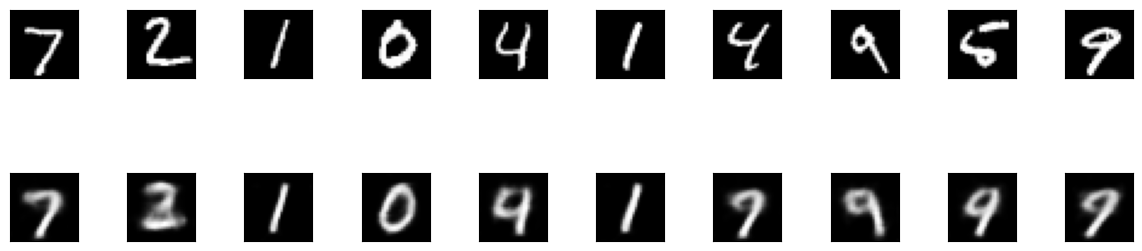

In [ ]:
from matplotlib import pyplot as plt
predicted = ae.predict(x_test[:20])

plt.figure(figsize=(30,3))
for i in range(10):
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(data_shape), cmap = 'gray')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(data_shape), cmap = 'gray')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

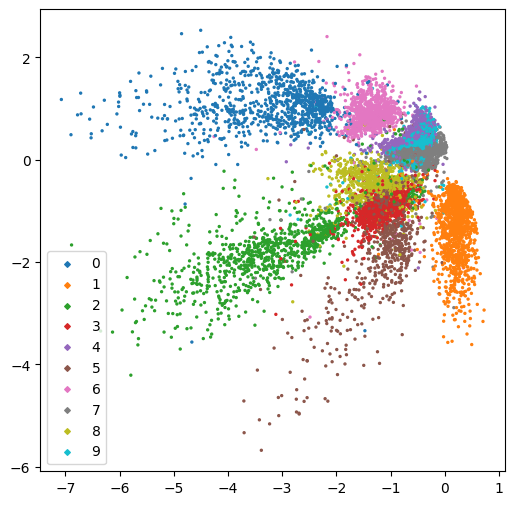

In [ ]:
from matplotlib import pyplot as plt

x_encoded = ae.encoder(x_test)
x_encoded = x_encoded.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], 
            c=[f'C{label}' for label in y_test], 
            s = 2
            )

for i in range(10):
    plt.scatter([], [], c=f'C{i}', label=str(i), s = 8, marker = 'D')

plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()

fig.add_trace(go.Scatter(
        x = x_encoded[:, 0],
        y = x_encoded[:, 1],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker=dict(size = [3]*len(y_test),
                    line_width=[0]*len(y_test),
                    color=[px.colors.qualitative.Plotly[l] for l in y_test])
    ))
fig.add_trace(go.Histogram(
        y = x_encoded[:, 1],
        xaxis = 'x2',
    ))

fig.add_trace(go.Histogram(
        x = x_encoded[:, 0],
        yaxis = 'y2',
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    # hovermode = 'closest',
    showlegend = False
)

fig.show()

15it [00:12,  1.24it/s]


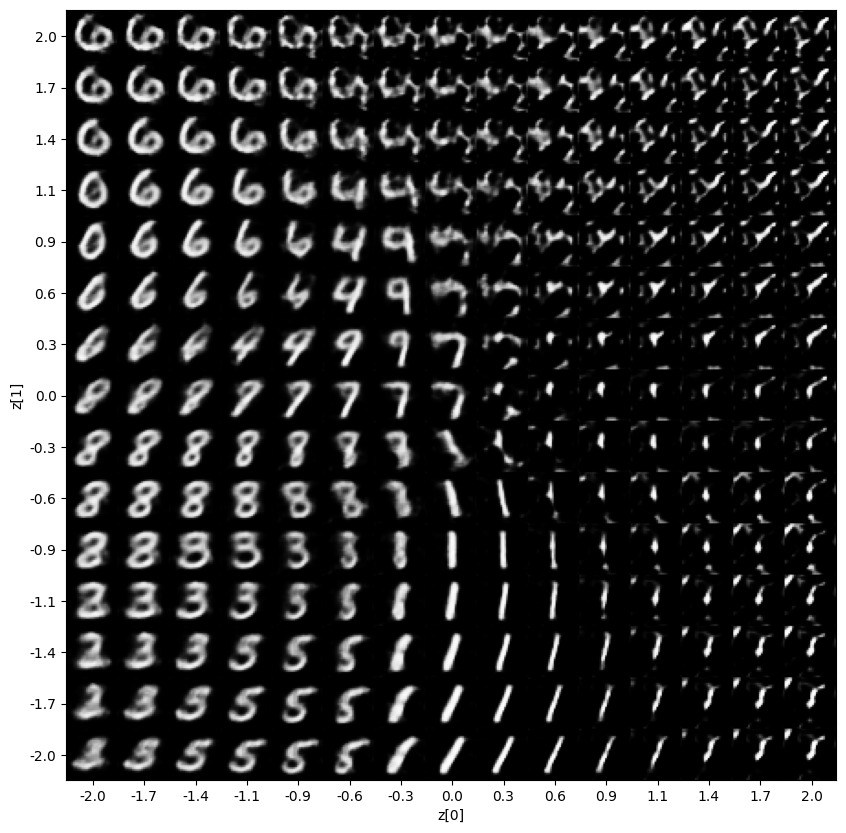

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_latent_space(model, n=15, figsize=10):
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in tqdm(enumerate(grid_y)):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = model.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(ae)